# Building a Crypto Trading Dashboard - The First Steps

***Introduction:***  
As discussed in my first blog post [here](https://www.google.com), the initial interest in data science stemmed from my desire to build a tool to download up-to-the minute trade history for a cryptocurrency coin so that I could calculate and analyze my own trading statistics in real-time like professional traders. 

My second blog post, along with this notebook, attempts to the answer the following question: 

```
Based on what I've learned in Phase 1, do I have the ability to build the beginnings of a Crypto Trading Dashboard that obtains, loads, and begins to analyze complete trade history in real-time for a crypto coin?***
```

Click [here](https://www.google.com) for the blog post.  

***UPDATE THIS LINK***

## System / Notebook Preparation
### Install necessary external packages

In [17]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


### Import necessary modules

In [18]:
import os
from os.path import exists
import gdown
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline
import requests
import datetime
import json
import time
debugging = True
import numpy as np

## Download historical trade data

Historical trade data is in two sources:
- The bulk of the historical trade data is hosted on Google drive. Currently this source holds trade data from the beginning of trading of this coin on Kraken (6/17/21) to the end of Q2-2022 (6/30/22). 
- More recent trade data must be downloaded from the Kraken API.  

### Download and load bulk trade data file from Google drive

In [19]:
# Make a data directory if it doesn't exist
if not os.path.exists("data"):
    ! mkdir data

zfile = 'data/sol.zip'
if not exists(zfile):
    # Download the historical trades from Google file repository
    url = 'https://drive.google.com/uc?id=1nrVrxbs7MaMHKpCObij9W-Mmq-B9QntK'
    gdown.download(url, zfile, quiet=False)

zf = zipfile.ZipFile(zfile)
# Load the SOL-USD trade data file from the zip file
df_bulk = pd.read_csv(zf.open("SOLUSD.csv"), header=None)
df_bulk.columns = ['date_time', 'price', 'quantity']
print(f"The bulk trade data file has {len(df_bulk):,} trade records in it.\n")
df_bulk.head()

The bulk trade data file has 5,236,388 trade records in it.



,date_time,price,quantity
0,1623943977,40.23,15.453348
1,1623943989,40.23,5.115190
2,1623943993,40.23,0.300000
3,1623944132,40.24,8.085485
4,1623944135,40.24,13.596725


#### Success
We've successfully downloaded and loaded the bulk trade data from Google Drive into a pandas dataframe.  As discussed, the bulk data only has trades up to 6/30/22.  Next, we need to load the more recent trade history.  

### Download recent trade data from Kraken API

Kraken makes its recent trade history available with its API.  To download this data, you send an http request with a unix formatted date/time value in the URL.  The API responds with the first 1,000 trades from that date/time.  You can use the last date/time of this trade data to then request the next 1000 trades.  Using this metho, you can loop through and download all recent trade data since the date of the last trade record you have. 

Example request:  https://api.kraken.com/0/public/Trades?pair=solusd&since=1624192440629160521

Note that Kraken only provides a maximum of 1,000 trades in each API request, and it limits its API responses to ~1 response per second.  This forces us to pause 1 second in between each request or we will get an error.

**Warning**

Downloading all trade data from the date of the end of the bulk data will take 30-45 min.  However, most of this data has been downloaded and saved in a data file within the data folder named 'data/api_dat.csv' so you don't have run it for long.  Running the following cell will bring current this API data file to the most recent trade. 

In [20]:
# constants
prefix="https://api.kraken.com/0/public/Trades?pair=solusd&since="
columns = ['price', 'quantity', 'date_time_long', "other_1", "other_2", "other_3", "trade_no"]
API_pause = 1    # Pause duration for API calls per API documentation

# Check to see if there is an api trade file in the data folder
if not exists('data/api_data.csv'):
    # No file
    df_api_new = pd.DataFrame(columns=columns)
    df_api_full = df_api_new.copy()
    print("API data file doesn't exist.  Start downloading from the date of the last record from bulk data...\n")
    # add microseconds to the last bulk trade trade time
    last = str(int(df_bulk['date_time'].max() + 1))
    last_date = datetime.datetime.utcfromtimestamp(int(last[0:10]))
    print("Last trade date in bulk file:           ", last_date, " (", last, ")", sep="")
    last = str(int(last))
    print(f"Current API trade list:        {len(df_api_full):>10,} records\n")
else:
    # Has a file - load it
    print("API data file exists.  Loading what we have, then start downloading the rest...\n")
    df_api_full = pd.read_csv('data/api_data.csv')
    first = str(df_api_full['date_time_long'].min())
    first_date = datetime.datetime.utcfromtimestamp(int(first[0:10]))
    last = str(df_api_full['date_time_long'].max())
    last_split = last.split(sep=".")
    new_last = last_split[0] + "." + str(int(last_split[1].ljust(9, '0'))+1)
    last_date = datetime.datetime.utcfromtimestamp(int(last[0:10]))
    print("First trade date in file:               ", first_date, " (", first, ")", sep="")
    print("Last trade date in file:                ", last_date, " (", last, ")", sep="")
    # print("New Last:                       ", new_last)
    print(f"Current API trade list:                {len(df_api_full):>10,} records\n\n", end="")
    
# Start endless loop (ends when the data is complete/current)
while 1:

    full_url = prefix + str(last)
    
    # Call the web request and confirm we received it
    print(f"Sending request:             \t\t{last}, {last_date}")
    response = requests.get(full_url)
    
    # Verify that the request was successful.  
    if response.status_code != 200:
        print("\n\nAPI request failed. Ending process...")
        break

    # Successful request
    response_dict = json.loads(response.text)
    if "result" not in response_dict.keys():
        print("Response received:           \t\tNo result. Pausing 5 seconds and then continuing...\n")
        time.sleep(5)
        continue
    
    trades = response_dict['result']['SOLUSD']   #response will have 1 duplicate trade in it.  drop it
    new_trade_count = len(trades)
    
    # if new trade data, add it to our list
    if new_trade_count > 0:
        # Build a new dataframe with the new trade data, and then concatenate it
        df_api_new = pd.DataFrame(trades)
        df_api_new.columns = columns
        df_api_full = pd.concat([df_api_full, df_api_new], ignore_index=True)
        
        # Confirm trades added
        print(f"Response received:           \t\t{new_trade_count:,} records added")
        print(f"Current API trade list:      \t\t{len(df_api_full):,} records\n")

        # Get new last
        last = str(int(response_dict['result']['last'])+1)
        last_date = datetime.datetime.utcfromtimestamp(int(last[0:10]))
        time.sleep(API_pause)
    else:
        print(f"Response received:           \t\t{new_trade_count:,} records added")
        print("\nTrade data is complete. Ending process...")
        break


API data file exists.  Loading what we have, then start downloading the rest...

First trade date in file:               2022-07-01 00:00:00 (1656633600.3850749)
Last trade date in file:                2022-12-05 03:51:27 (1670212287.2587216)
Current API trade list:                 1,309,266 records

Sending request:             		1670212287.2587216, 2022-12-05 03:51:27
Response received:           		117 records added
Current API trade list:      		1,309,383 records

Sending request:             		1670214325471264191, 2022-12-05 04:25:25
Response received:           		0 records added

Trade data is complete. Ending process...


### Save downloaded recent trade data


In [21]:
# Drop any duplicates that may have occurred (shouldn't be any) 
df_api_full = df_api_full.drop_duplicates(keep='first')

# Save it
df_api_full.to_csv('data/api_data.csv', index=False)

### Load recent trade data from file

In [22]:
df_api_from_file_1 = pd.read_csv('data/api_data.csv')
df_api_from_file_1

,price,quantity,date_time_long,other_1,other_2,other_3,trade_no
0,33.73,0.296384,1.656634e+09,b,l,NaN,5238234
1,33.75,0.958930,1.656634e+09,b,l,NaN,5238235
2,33.72,53.232510,1.656634e+09,s,m,NaN,5238236
3,33.56,4.932385,1.656634e+09,b,l,NaN,5238237
4,33.57,29.097615,1.656634e+09,b,l,NaN,5238238
...,...,...,...,...,...,...,...
1309377,13.91,0.100000,1.670214e+09,b,m,NaN,6547610
1309378,13.90,3.688785,1.670214e+09,s,m,NaN,6547611
1309379,13.90,1.370507,1.670214e+09,s,m,NaN,6547612
1309380,13.90,20.640708,1.670214e+09,s,m,NaN,6547613


In [23]:
# Make a copy of the date_time column and cut off the microseconds
df_api_from_file_1['date_time'] = df_api_from_file_1['date_time_long'].map(lambda x: int(str(x)[0:10]))

# Carve out what we need
df_api_from_file_2 = df_api_from_file_1[['price', 'quantity', 'date_time']]
df_api_from_file_2.head()

,price,quantity,date_time
0,33.73,0.296384,1656633600
1,33.75,0.958930,1656633614
2,33.72,53.232510,1656633622
3,33.56,4.932385,1656633646
4,33.57,29.097615,1656633646


### Combine bulk and recent trade data

In [24]:
# Combine bulk and recent trade data data frames
df_combined = pd.concat([df_bulk, df_api_from_file_2], ignore_index=True)
df_combined.head()

,date_time,price,quantity
0,1623943977,40.23,15.453348
1,1623943989,40.23,5.115190
2,1623943993,40.23,0.300000
3,1623944132,40.24,8.085485
4,1623944135,40.24,13.596725


### Add features that can help us create visualizations
- Extended price
- A new column represented the date_time formated as a datetime object

In [25]:
# Make copy of that column and convert to date/time
df_combined['nk_date_time'] = df_combined['date_time']
df_combined['nk_date_time'] = pd.to_datetime(df_combined['nk_date_time'],unit='s')

# Add extended_price
df_combined['ext_price'] = df_combined['price'] * df_combined['quantity']

# check it out
df_combined.head()

,date_time,price,quantity,nk_date_time,ext_price
0,1623943977,40.23,15.453348,2021-06-17 15:32:57,621.688186
1,1623943989,40.23,5.115190,2021-06-17 15:33:09,205.784100
2,1623943993,40.23,0.300000,2021-06-17 15:33:13,12.069000
3,1623944132,40.24,8.085485,2021-06-17 15:35:32,325.359900
4,1623944135,40.24,13.596725,2021-06-17 15:35:35,547.132200


We can see from the cell below that there are a lot of trade records with the same date_time value.  This represents multiple trades performed within the same second.  We want to combine these records for visualizations to be accurate so that each time value only has one record. 

In [26]:
df_combined.duplicated(subset=['date_time']).value_counts()

True     4253588
False    2292182
dtype: int64

In [27]:
# Group by time value (seconds)
df_combined_g_s = df_combined.groupby('nk_date_time')[['ext_price', 'quantity']].agg(['sum'])

df_combined_g_s['avg_price'] = df_combined_g_s['ext_price'] / df_combined_g_s['quantity']
df_combined_g_s.reset_index(inplace=True)
df_combined_g_s.columns = ['nk_date_time', 'ext_price', 'quantity', 'avg_price']
df_combined_g_s.head()

,nk_date_time,ext_price,quantity,avg_price
0,2021-06-17 15:32:57,621.688186,15.453348,40.23
1,2021-06-17 15:33:09,205.784100,5.115190,40.23
2,2021-06-17 15:33:13,12.069000,0.300000,40.23
3,2021-06-17 15:35:32,325.359900,8.085485,40.24
4,2021-06-17 15:35:35,547.132200,13.596725,40.24


In [28]:
len(df_combined_g_s)

2292182

**Use Pandas Grouping to analyze data using different time intervals**

As you can see, grouping by second reduced the number of rows by almost two-third (from 6 million to 2 million), while the trade data is still highly detailed to the time period it relates.  In reality, we aren't at the point of analyzing trade data by seconds yet.  Let's group by days and months to visualize some high level trends.

In [29]:
# Group by day
df_combined_g_d = df_combined_g_s.groupby(pd.Grouper(key='nk_date_time', freq='d'))[['ext_price', 'quantity']].agg('sum')
df_combined_g_d['avg_price'] = df_combined_g_d['ext_price'] / df_combined_g_d['quantity']
df_combined_g_d.reset_index(inplace=True)
df_combined_g_d.columns = ['nk_date_time', 'ext_price', 'quantity', 'avg_price']

# Group by month
df_combined_g_m = df_combined_g_s.groupby(pd.Grouper(key='nk_date_time', freq='m'))[['ext_price', 'quantity']].agg('sum')
df_combined_g_m['avg_price'] = df_combined_g_m['ext_price'] / df_combined_g_m['quantity']
df_combined_g_m.reset_index(inplace=True)
df_combined_g_m.columns = ['nk_date_time', 'ext_price', 'quantity', 'avg_price']

## Visualize the trade data

Visualize daily average price and volume history

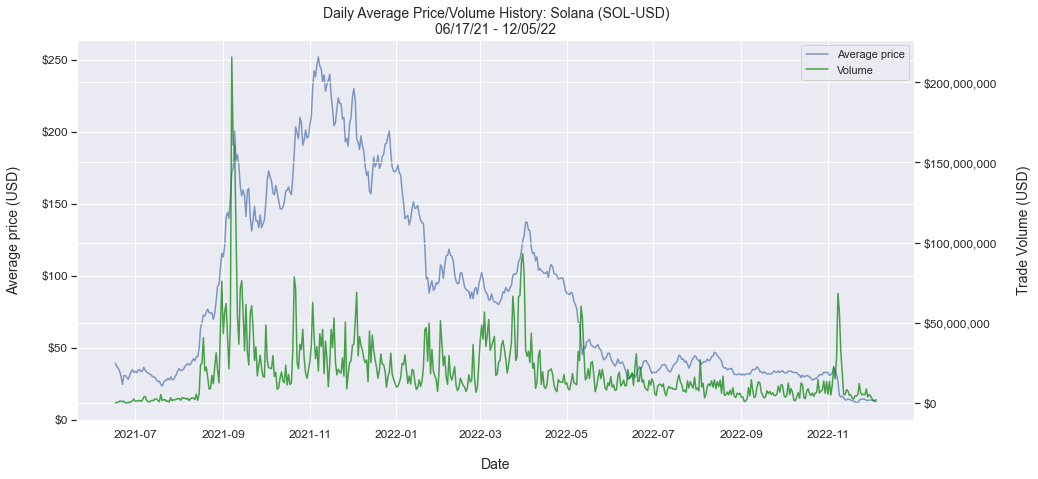

In [30]:
min_trade_date = df_combined_g_d.nk_date_time.min()
max_trade_date = df_combined_g_d.nk_date_time.max()

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 7))

new_title = "Daily Average Price/Volume History: Solana (SOL-USD)\n"
new_title = new_title + min_trade_date.strftime('%m/%d/%y') + " - " + max_trade_date.strftime('%m/%d/%y')
ax.set_title(new_title, fontsize=14)

x = df_combined_g_d['nk_date_time'] #tr.strftime("%m-%y")
y = df_combined_g_d['avg_price']
ax.set_ylabel("Average price (USD)", fontsize=14, labelpad=20)
ax.set_xlabel("Date", fontsize=14, labelpad=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.set_major_formatter('${x:,.0f}')
myFmt = mdates.DateFormatter('%m/%d/%y')
ax.xaxis.set_major_formatter(myFmt)
sns.lineplot(x=x,y=y,ci=None, ax=ax, alpha=.7, label='Average price');

ax2=ax.twinx()
x=df_combined_g_d['nk_date_time']
y=df_combined_g_d['ext_price']
ax2.set_ylabel("Trade Volume (USD)", fontsize=14, labelpad=20)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.yaxis.set_major_formatter('${x:,.0f}')
sns.lineplot(x=x,y=y,ci=None, ax=ax2, color='green', alpha=.7, label='Volume');

ax.legend_.remove()
ax2.legend_.remove()
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes);


Visualize trade volume history by month

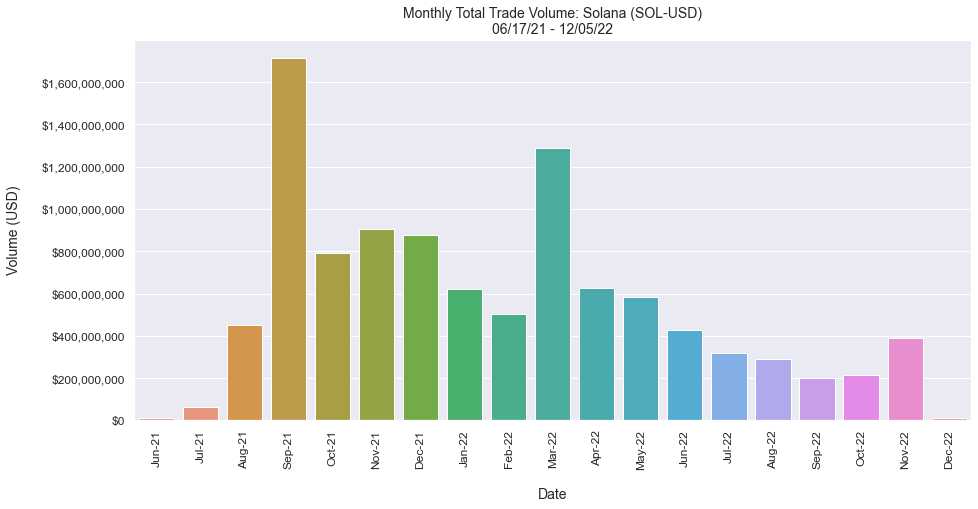

In [31]:
min_trade_date = df_combined_g_d.nk_date_time.min()
max_trade_date = df_combined_g_d.nk_date_time.max()

months = df_combined_g_m['nk_date_time'].tolist()
months = [x.strftime('%b-%y') for x in months]

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(data=df_combined_g_m,x=months,y="ext_price",ci=None, ax=ax);
new_title = "Monthly Total Trade Volume: Solana (SOL-USD)\n"
new_title = new_title + min_trade_date.strftime('%m/%d/%y') + " - " + max_trade_date.strftime('%m/%d/%y')
ax.set_title(new_title, fontsize=14)
ax.set_ylabel("Volume (USD)", fontsize=14, labelpad=20)
ax.set_xlabel("Date", fontsize=14, labelpad=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.set_major_formatter('${x:,.0f}')
#myFmt = mdates.DateFormatter('%m/%y')
#ax.xaxis.set_major_formatter(myFmt)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Conclusion

Going back to the question posed in the introduction of this notebook: 

```
Based on what I've learned in Phase 1, do I have the ability to build the beginnings of a Crypto Trading Dashboard that obtains, loads, and begins to analyze complete trade history in real-time for a crypto coin?***
```
The answer is ***Yes***. 

As demonstrated, I pythonically:
1. Downloaded complete trade history (from the first trade to the most recent in real-time) for a crypto coin from both Google drive and the Kraken API,
2. Loaded and combined the trade history from the different sources, 
3. Added necessary features like extended_price and formatted dates,
4. Aggregated the trade history with respect to different time periods (daily and monthly)
5. Began to analyze the data through visualiation.  

***Next steps:***

In the future, I can:
1. Identify statistics that are most relevant to real-time trade analysis and create code to calculate these statistics, 
2. Transition from a **'download then analyze'*** approach to a ***'download and analyze continously'*** approach.
